In [1]:

import brainpy.math as bm
import numpy as np
from PCCAN_utils import get_tuningMap, animate_sweeps
from models import PC_cell_topdown, PC_cell_topdown_asym

#for generting behavioral trajectory
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

#for plotting
import matplotlib.pyplot as plt
#grid spec
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import seaborn as sns
import time

import os
from scipy.signal import find_peaks
from scipy.ndimage import center_of_mass
from scipy.stats import pearsonr

import sys
sys.path.append('/home/zilong/Desktop/HoneycombSweeps/CircularLinearReg')
from core import cl_corr


%matplotlib inline  
%load_ext autoreload 
%autoreload 2

## Section 1: generate behavioral running trajectories in open fields using RatInABox

/tmp/ipykernel_1342728/2125361828.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("cool")  # 'winter' transitions from green to blue


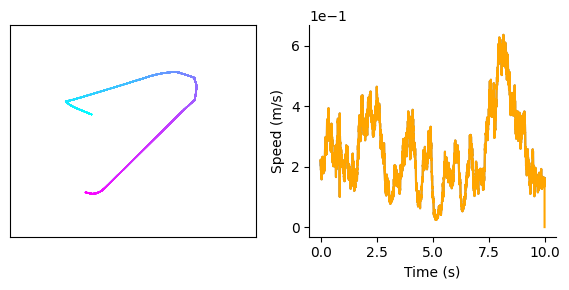

In [21]:
np.random.seed(1234)

Env = Environment(params={
    'scale':1,
    "dimensionality": "2D",
})

dur = 10 #in seconds
dt = 0.001 #in seconds
speed_mean = 0.2 #in m/s
speed_std = 0.0 #in m/s
rotation_velocity_std = 1 * (np.pi / 180) #in rad/s


Ag = Agent(Env, params = {
    "dt": dt,
    "speed_mean":speed_mean,
    "speed_std": speed_std,
    "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
    })

while Ag.t < dur:
    Ag.update(drift_velocity=None)

Position = Ag.history['pos']
Position = np.array(Position) + 0.5 #add 0,5 is to make the running rat in the middle of the box [from 0.5 to 1.5], the size of the neuronal sheet is 2by2. we did so to remove the periodic boundary effect
# Position_2_2pi = Position*(2*np.pi)-np.pi
Vel = Ag.history['vel']
Speed = np.linalg.norm(Vel, axis=1) * dt # meters per ms

diff = np.diff(Position, axis=0)
Vel2 = np.zeros_like(Position)
Vel2[:-1,:] = diff
Speed2 = np.linalg.norm(Vel2, axis=1)

#visualize the trajectory
fig, axs = plt.subplots(1, 2, figsize=(6,3))
ax = axs[0]
# Set up a colour map from green to blue
cmap = cm.get_cmap("cool")  # 'winter' transitions from green to blue

# Plot each segment with a different colour
for i in range(len(Position) - 1):
    ax.plot(
        [Position[i, 0], Position[i + 1, 0]], 
        [Position[i, 1], Position[i + 1, 1]], 
        color=cmap(i / len(Position)), 
        linewidth=1
    )
ax.axis('equal')
ax.set_xticks([0,2])
ax.set_yticks([0,2])

ax = axs[1]
ax.plot(np.arange(len(Speed))*dt, Speed/dt, label='speed', color='grey')
ax.plot(np.arange(len(Speed))*dt, Speed2/dt, label='speed2', color='orange')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel('Speed (m/s)')
ax.set_xlabel('Time (s)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

## Section 4: turn on firing rate adaptation. Adaptation makes the bump do theta sweeps along the trajectory. Top down input makes the sweeps attract to the goal location. So there are two sweeps competing with each other. The bump will do theta sweeps along the trajectory and also attract to the goal location.

In [22]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.)

#hyperparameters
m0 = 20  #adaptation strength as zero
z_min = 0; z_max = 2 #the size of the environment, have to be the same as the environment size
duration = int(dur/dt) #simulation duration of the trajectory
alpha_pc = 0.3 #theta modulation scale
v0 = 1/1000 #baseline speed per ms  
T_theta = 100 #ms, length of a theta cycle; frequency=10Hz
num = 50 #number of PC cells on x or y axis
goal_loc = (0.75, 0.75)
bm.clear_buffer_memory(platform='gpu')


PC_net = PC_cell_topdown_asym(num=num, 
                        tau=10, 
                        tauv=100, 
                        m0=m0, 
                        k=1, 
                        a=0.15, 
                        A=10.0, 
                        J0=5.0, 
                        goal_a=0.3,
                        goal_A=3.0,
                        asym_J0 = 0.1,
                        asym_a = 0.5,
                        z_min=z_min, 
                        z_max=z_max,    
                        conn_noise=0., 
                        rec_noise=0.,     
                        goal_loc=goal_loc,
                        topdown=True,
                        asymmetry=True)


def runNet(i, Animal_location, Speed):
    theta_mod_strength = alpha_pc * 1/v0 * Speed #faster run, higher theta modulation strength
    #calculate thetamodulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    ThetaModulator_BU = 1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi)
    Topdown_mod = 1.0 #1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi + bm.pi)
    
    #update place cell network using step_run
    PC_net.step_run(i, Animal_location, ThetaModulator_BU, Topdown_mod)
    
    #get intermidiate results
    pc_activity = PC_net.r
    pc_bumcenter = PC_net.center
    return pc_activity, pc_bumcenter, ThetaModulator_BU

#flip position make end to start, and start to end
Position = Position[::-1]
Speed = Speed[::-1]

time_steps = np.arange(len(Position))
print('Running simulation...')
pc_activity, pc_bumpcenter, ThetaModulator_BU = bm.for_loop(runNet, (time_steps, Position, Speed))

#animate the sweeps and save the animation
print('Animating...')
save_path = './animations/'
filename_prefix = 'Plain_adaptation_'
#add time to the filename
time_str = time.strftime("%Y%m%d-%H%M%S")
filename_prefix = filename_prefix + time_str + '_'

animate_sweeps(Position, pc_activity, num, duration, Speed, m0, z_max, n_step=10, goal_loc=goal_loc, save_path=save_path, filename_prefix=filename_prefix)


Running simulation...


MovieWriter imagemagick unavailable; using Pillow instead.


Animating...
Animation saved to ./animations/Plain_adaptation_20241213-145404_20.gif


## Section 5: Simulate the network with a long trajectory and plot place fields of cells

[]

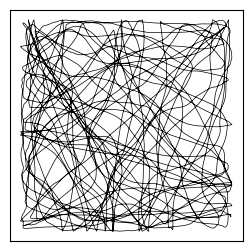

In [2]:
np.random.seed(111)

Env = Environment(params={
    'scale':1,
    "dimensionality": "2D",
})

dur = 400 #in seconds
dt = 0.001 #in seconds
speed_mean = 0.2 #in m/s
speed_std = 0.0 #in m/s
rot = 60
rotation_velocity_std = rot * (np.pi / 180) #in rad/s

#if traj exist, load it, otherwise generate it
if os.path.exists('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'_rot'+str(rot)+'.npz'):
    data = np.load('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'_rot'+str(rot)+'.npz')
    Position = data['Position'] #add 0,5 is to make the running rat in the middle of the box [from 0.5 to 1.5], the size of the neuronal sheet is 2by2. we did so to remove the periodic boundary effect
    Speed = data['Speed']
    Vel = data['Velocity']
else:
    Ag = Agent(Env, params = {
        "dt": dt,
        "speed_mean":speed_mean,
        "speed_std": speed_std,
        "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
        })

    while Ag.t < dur:
        Ag.update(drift_velocity=None)

    Position = Ag.history['pos'] 
    Position = np.array(Position) + 0.5 #add 0,5 is to make the running rat in the middle of the box [from 0.5 to 1.5], the size of the neuronal sheet is 2by2. we did so to remove the periodic boundary effect
    # Position_2_2pi = Position*(2*np.pi)-np.pi
    Vel = Ag.history['vel']
    Vel = np.array(Vel)
    Speed = np.linalg.norm(Vel, axis=1) * dt # meters per ms
    
    #calculate moving direction from Vel whihc is (x,y) at each time step
    moving_direction = np.zeros(len(Vel))
    for i in range(len(Vel)):
        moving_direction[i] = np.arctan2(Vel[i][1], Vel[i][0])
    
    np.savez('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'_rot'+str(rot)+'.npz', Position=Position, Speed=Speed, Velocity=Vel, Direction=moving_direction, dur=dur)

fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.plot(Position[:,0], Position[:,1], linewidth=0.5, color='black')
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])


### Simulate the PC network with a long running trajectory

In [3]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

#hyperparameters
m0 = 20 #adaptation strength
z_min = 0; z_max = 2 #the size of the environment, have to be the same as the environment size
duration = int(dur/dt) #simulation duration of the trajectory
alpha_pc = 0.3 #theta modulation scale
v0 = 1/1000 #baseline speed per ms  
T_theta = 100 #ms, length of a theta cycle; frequency=10Hz
num = 50 #number of PC cells on x or y axis
goal_loc = [0.75, 0.75]

PC_net = PC_cell_topdown_asym(num=num, 
                        tau=10, 
                        tauv=100, 
                        m0=m0, 
                        k=1, 
                        a=0.15, 
                        A=10.0, 
                        J0=5.0, 
                        goal_a=0.3,
                        goal_A=3.0,
                        asym_J0 = 0.1,
                        asym_a = 0.5,
                        z_min=z_min, 
                        z_max=z_max,    
                        conn_noise=0., 
                        rec_noise=0.,     
                        goal_loc=goal_loc,
                        topdown=True,
                        asymmetry=True)

def runNet(i, Animal_location, Speed):
    theta_mod_strength = alpha_pc * 1/v0 * Speed #faster run, higher theta modulation strength
    #calculate thetamodulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    ThetaModulator_BU = 1.0+theta_mod_strength*bm.cos(theta_phase*2*bm.pi)
    Topdown_mod = 1.0 #0.6 #1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi + bm.pi)
    
    #update place cell network using step_run
    PC_net.step_run(i, Animal_location, ThetaModulator_BU, Topdown_mod)
    
    #get intermidiate results
    pc_activity = PC_net.r
    pc_bumcenter = PC_net.center
    return pc_activity, pc_bumcenter, theta_phase, ThetaModulator_BU

time_steps = np.arange(len(Position))
print('Running simulation...')

@bm.jit
def run(time, pos, speed):
    return bm.for_loop(runNet, (time, pos, speed))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Position), num, num))
pc_bumpcenter = np.empty((len(Position), 2))
theta_phase = np.empty(len(Position))
theta_rhythm = np.empty(len(Position))

for i in range(0, len(Position), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Position)*100))
    pc_activity_i, pc_bumpcenter_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], Position[i:i+simulate_time], Speed[i:i+simulate_time])
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

2024-12-13 14:58:47.775461: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...
Simulation progress: 0%
Simulation progress: 12%
Simulation progress: 25%
Simulation progress: 37%
Simulation progress: 50%
Simulation progress: 62%
Simulation progress: 75%
Simulation progress: 87%
Simulation progress: 100%


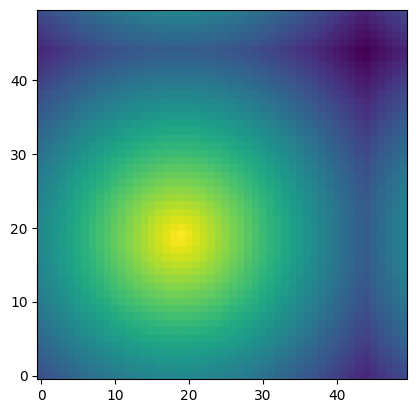

In [4]:
plt.imshow(PC_net.gd_conn[1500,:].reshape(50,50), origin='lower')  

### get sweep direction relative to the goal direction

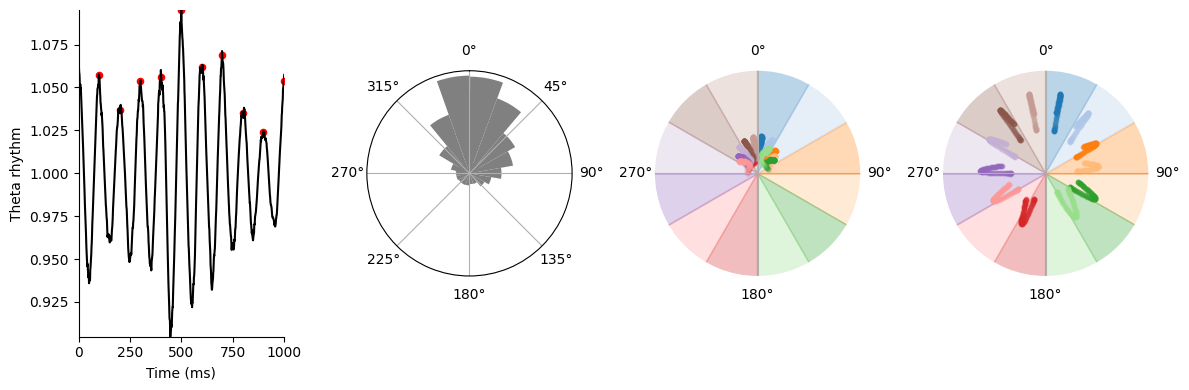

In [4]:
#find peak using scipy.signal.find_peaks
peaks, _ = find_peaks(theta_phase)

#plot theta_rhythm and mark peaks as red dots
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
#gridspec
fig = plt.figure(figsize=(12, 4), dpi=100)
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])

ax = plt.subplot(gs[0])
ax.plot(theta_rhythm, color='black')
ax.scatter(peaks, theta_rhythm[peaks], color='red', s=20)
ax.set_xlim(0, 1000)
ax.set_ylim(np.min(theta_rhythm[:1000]), np.max(theta_rhythm[:1000]))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta rhythm')
sns.despine()

Angle_at_zeroPhase = []
BumpAngle_2_goal = [] #same dime as Angle_at_zeroPhase
BumpAngle_at_all_phase = []
BumpDist_2_pos = []
BumpDist_2_pos_centermass = []
BumpAngle_at_all_phase_centermass = []

#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0] - Position[peaks[i], 0], goal_loc[1] - Position[peaks[i], 1]])
    #calculate the angle between from vector to the moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
    angle = np.degrees(angle) % 360
    Angle_at_zeroPhase.append(angle)
    
    bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]/num * z_max
    BumpAngle = []
    BumpDist = []
    BumpAngle_cm = []
    BumpDist_cm = []
    for j in range(len(bumpTraj_in_Acycle)):
        
        #calculate the angle between sweeps and Position at the peak (zero phase)
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - Position[peaks[i], 0], bumpTraj_in_Acycle[j, 1] - Position[peaks[i], 1]])
        # Calculate sweep angle relative to goal
        angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(vec[1], vec[0])
        angel2 = np.degrees(angle2) % 360
        BumpAngle_2_goal.append(angle2)
        
        #calculate the angle between sweeps and moving direction
        angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
        angle3 = np.degrees(angle3) % 360
        BumpAngle.append(angle3)
        
        #calculate bump distance to the position
        dist = np.linalg.norm(vec2)
        # dist = np.where(dist > 0.5, 1.0 - dist, dist)
        BumpDist.append(dist)
        
        #calculate pc_activity[peaks[i]+j, :, :] center of mass
        bump = pc_activity[peaks[i]+j, :, :]
        center1, center0 = center_of_mass(bump)
        center1 = center1/num * z_max
        center0 = center0/num * z_max
        vec_cm = np.array([center0 - Position[peaks[i], 0], center1 - Position[peaks[i], 1]])
        dist_cm = np.linalg.norm(vec_cm)
        BumpDist_cm.append(dist_cm)
        
        #calculate the angle between sweeps from center of mass and and moving direction
        angle4 = np.arctan2(vec_cm[1], vec_cm[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
        angle4 = np.degrees(angle4) % 360
        BumpAngle_cm.append(angle4)
        
        
    BumpAngle_at_all_phase.append(BumpAngle)
    BumpAngle_at_all_phase_centermass.append(BumpAngle_cm)
    BumpDist_2_pos.append(BumpDist)
    BumpDist_2_pos_centermass.append(BumpDist_cm)

ax = plt.subplot(gs[1], projection='polar') 
ax.hist(BumpAngle_2_goal, bins=36, color='grey')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])

####################################################################################################

ax = plt.subplot(gs[2], projection='polar')
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_ylim(0, 0.2)
ax.spines['polar'].set_visible(False)
#plasce 0 at the top
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#initialize 12 colors from tab20
colors = sns.color_palette("tab20", 12)
#color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

# Shade each sector of the polar plot with the respective color
for i in range(360 // 30):
    ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 1, color=colors[i], alpha=0.3)

scatter_angles = []
scatter_angles_cm = []
scatter_distances = []
scatter_distances_cm = []
scatter_colors = []
scatter_alphas = []

sweep_info = {}

#clasifiy sweeps into 12 bins with 30 degree each
for goal_ang, sweep_angs, sweep_dist, sweep_angs_cm, sweep_dist_cm in zip(Angle_at_zeroPhase, BumpAngle_at_all_phase, BumpDist_2_pos, BumpAngle_at_all_phase_centermass, BumpDist_2_pos_centermass):
    goal_ang = goal_ang % 360
    indx = int(goal_ang // 30)
    #append sweep_angs and sweep_dist to a dictionary with indx as key
    if indx not in sweep_info:
        sweep_info[indx] = []
    sweep_info[indx].append((sweep_angs, sweep_dist, sweep_angs_cm, sweep_dist_cm))

#in each angular bin, calculate the mean sweep angle and distance
for key in sweep_info:
    sweep_info_key = sweep_info[key]
    SA = []
    SD = []
    SA_cm = []
    SD_cm = []
    for sweep_angs, sweep_dist, sweep_angs_cm, sweep_dist_cm in sweep_info_key:
        SA.append(sweep_angs[0:100])
        SD.append(sweep_dist[0:100])
        SA_cm.append(sweep_angs_cm[0:100])
        SD_cm.append(sweep_dist_cm[0:100])
    #to numpy array using stack
    SA = np.stack(SA)
    SD = np.stack(SD)
    SA_cm = np.stack(SA_cm)
    SD_cm = np.stack(SD_cm)
    
    # Convert angles in SA to complex numbers
    complex_angles = np.exp(1j * np.radians(SA))  # Convert angles to radians and then to complex form
    mean_complex = np.mean(complex_angles, axis=0)  # Calculate mean in complex plane
    SA_mean = np.degrees(np.angle(mean_complex)) % 360  # Convert back to degrees and wrap to 0-360
    
    complex_angles_cm = np.exp(1j * np.radians(SA_cm))  # Convert angles to radians and then to complex form
    mean_complex_cm = np.mean(complex_angles_cm, axis=0)  # Calculate mean in complex plane
    SA_cm_mean = np.degrees(np.angle(mean_complex_cm)) % 360  # Convert back to degrees and wrap to 0-360
    
    # Calculate mean distance
    SD_mean = np.mean(SD, axis=0)
    SD_cm_mean = np.mean(SD_cm, axis=0)
    
    # Store points for batch scatter plot
    for i, (ang, dist, ang_cm, dist_cm) in enumerate(zip(SA_mean, SD_mean, SA_cm_mean, SD_cm_mean)):
        scatter_angles.append(np.radians(ang))
        scatter_distances.append(dist)
        scatter_angles_cm.append(np.radians(ang_cm))
        scatter_distances_cm.append(dist_cm)
        scatter_colors.append(colors[key])
        alpha = i/len(SA_mean)/2
        scatter_alphas.append(alpha)
    


#plot mean sweep agle and distance in each angular bin
for i in range(len(scatter_angles)):
    ax.scatter(scatter_angles[i], scatter_distances[i], color=scatter_colors[i], s=10, alpha=scatter_alphas[i])


####################################################################################################

ax = plt.subplot(gs[3], projection='polar')
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_ylim(0, 0.2)
ax.spines['polar'].set_visible(False)
#plasce 0 at the top
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#initialize 12 colors from tab20
colors = sns.color_palette("tab20", 12)
#color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

# Shade each sector of the polar plot with the respective color
for i in range(360 // 30):
    ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 1, color=colors[i], alpha=0.3)
    
#plot mean sweep agle and distance in each angular bin
for i in range(len(scatter_angles_cm)):
    ax.scatter(scatter_angles_cm[i], scatter_distances_cm[i], color=scatter_colors[i], s=10, alpha=scatter_alphas[i])
plt.tight_layout()

### check if sweep length depending on the distance to goal location

Pearson correlation coefficient: 0.121, p-value: 0.000


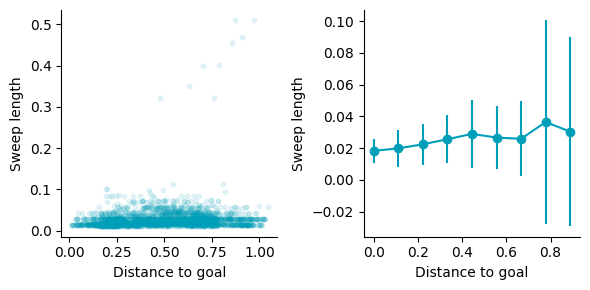

In [5]:
peaks, _ = find_peaks(theta_phase)

Dist2goal = []
SweepLength = []
#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0]- Position[peaks[i], 0], goal_loc[1] - Position[peaks[i], 1]])
    #get the distance
    dist = np.linalg.norm(vec)
    # dist = np.where(dist > 0.5, 1.0 - dist, dist)
    
    bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]/num
    sweepdist2position = []
    for j in range(len(bumpTraj_in_Acycle)):
        #calculate the angle between sweeps and Position at the peak (zero phase)
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - Position[peaks[i], 0], bumpTraj_in_Acycle[j, 1] - Position[peaks[i], 1]])
        #get the distance
        dist2 = np.linalg.norm(vec2)
        # dist2 = np.where(dist2 > 0.5, 1.0 - dist2, dist2)
        sweepdist2position.append(dist2)
    sweep_length = np.max(sweepdist2position) - np.min(sweepdist2position)
    if sweep_length < 0.01:
        continue
    Dist2goal.append(dist)
    SweepLength.append(sweep_length)

#plot SweepLength against Dist2goal
fig, axs = plt.subplots(1, 2, figsize=(6,3), dpi=100)
ax = axs[0]
ax.scatter(Dist2goal, SweepLength, color='#009FB9', s=10, alpha=0.1)
ax.set_xlabel('Distance to goal')
ax.set_ylabel('Sweep length')
sns.despine()

ax = axs[1]
#split the data into 10 bins and plot mean and std
Dist2goal = np.array(Dist2goal)
SweepLength = np.array(SweepLength)
bins = np.linspace(0, 1, 10)
mean = []
std = []

for i in range(len(bins)-1):
    indx = np.where((Dist2goal >= bins[i]) & (Dist2goal < bins[i+1]))
    mean.append(np.mean(SweepLength[indx]))
    std.append(np.std(SweepLength[indx]))
ax.errorbar(bins[:-1], mean, yerr=std, fmt='o-', color='#009FB9')
ax.set_xlabel('Distance to goal')
ax.set_ylabel('Sweep length')
sns.despine()

plt.tight_layout()

#peasrson correlation
r, p = pearsonr(Dist2goal, SweepLength)
print('Pearson correlation coefficient: %.3f, p-value: %.3f' % (r, p))
    

## Check spike phase against distance to goal, as well as ConSink cells

### plot spike phase against distance to goal for all cells

In [6]:
# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase

#for cell index x vary from 0-49 and y vary from 0-49, plot the tuning map and the phase of spikes at each time step

all_clcc = []
all_RelativeDirection = []
for xi in range(15, 35, 3):
    for yi in range(15, 35, 3):
        print('Processing cell index: ', xi, yi)
        cellindex = [xi, yi]

        fig = plt.figure(figsize=(8,3), dpi=100)
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
        
        ####################################################################################################
        ax = plt.subplot(gs[0])
        #plot the tuning map
        Position_norm = (Position - Position.min() - 1e-5)/(Position.max() - Position.min())
        dim = num//2
        tuningMap = get_tuningMap(pc_activity, 
                                    Position_norm, 
                                    cellindex_x=cellindex[0],
                                    cellindex_y=cellindex[1],
                                    shift = 0,
                                    filter=True,
                                    samples_per_sec=1000,
                                    dim=dim)
        ax.imshow(tuningMap, cmap='Blues', origin='lower')

        #mark the goal location
        goal_x = (goal_loc[0]- Position.min())/(Position.max() - Position.min())*dim
        goal_y = (goal_loc[1]- Position.min())/(Position.max() - Position.min())*dim
        ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

        ax.axis('off')


        ####################################################################################################
        #Phase against distance to goal
        ax = plt.subplot(gs[1])
        
        Dist2G = []
        SpikePhase = []
        RelativeDirection = []

        r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

        for i in range(len(Position)):
            #get the distance to goal_loc
            dist_i = np.linalg.norm(Position[i] - goal_loc)
            # dist_i = np.where(dist_i > 0.5, 1.0 - dist_i, dist_i)
  
            #get the vec pointing from Position to goal_loc
            vec = goal_loc - Position[i]
            #get the angle between vec and moving direction
            angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
            angle = np.degrees(angle) % 360
            
            #get the phase at current time step i
            phase_i = theta_phase[i]*np.pi*2
            
            spikes = np.random.poisson(r[i]*dt*5)
            if spikes > 0:
                #save dist_i and phase_i
                Dist2G.append(dist_i)
                SpikePhase.append(phase_i)
                RelativeDirection.append(angle)
                all_RelativeDirection.append(angle)

        Dist2G = np.asarray(Dist2G)
        SpikePhase = np.asarray(SpikePhase)

        ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

        ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

        circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)
        all_clcc.append(circ_lin_corr)
        if True:
            # Plot the circular-linear regression
            x = np.linspace(-np.pi, np.pi, 100)
            y = 2 * np.pi * slope * x + phi0
            ax.plot(x, y, color='red', linewidth=1)
            #add intercepr of 2*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
            ax.plot(x, y, color='red', linewidth=1)
            #add intercepr of 4*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
            ax.plot(x, y, color='red', linewidth=1)
            #substrac intercepr of 2*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
            ax.plot(x, y, color='red', linewidth=1) 

        # ax[0].set_xlabel('Head direction')
        ax.set_xlabel('Dist2Goal', fontsize=10)
        ax.set_ylabel('Theta phase', fontsize=10)
        #activity colorbar
        ax.set_xlim(0, 1)
        ax.set_xticks([0, 1])
        ax.set_ylim(0, 4*np.pi)
        ax.set_yticks([0, 2*np.pi, 4*np.pi])
        ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   

        sns.despine()
        
        ####################################################################################################
        #ConSink
        ax = plt.subplot(gs[2], projection='polar')
        #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
        ax.hist(np.radians(RelativeDirection), bins=36, color='lightgrey', edgecolor='black')
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_yticks([])

        plt.tight_layout()
        
        plt.savefig('./figures/phasevsgoaldist/Cell_'+str(cellindex[0])+'_'+str(cellindex[1])+'.png', dpi=300)
        
        plt.close()

Processing cell index:  15 15
Processing cell index:  15 18
Processing cell index:  15 21
Processing cell index:  15 24
Processing cell index:  15 27
Processing cell index:  15 30
Processing cell index:  15 33
Processing cell index:  18 15
Processing cell index:  18 18
Processing cell index:  18 21
Processing cell index:  18 24
Processing cell index:  18 27
Processing cell index:  18 30
Processing cell index:  18 33
Processing cell index:  21 15
Processing cell index:  21 18
Processing cell index:  21 21
Processing cell index:  21 24
Processing cell index:  21 27
Processing cell index:  21 30
Processing cell index:  21 33
Processing cell index:  24 15
Processing cell index:  24 18
Processing cell index:  24 21
Processing cell index:  24 24
Processing cell index:  24 27
Processing cell index:  24 30
Processing cell index:  24 33
Processing cell index:  27 15
Processing cell index:  27 18
Processing cell index:  27 21
Processing cell index:  27 24
Processing cell index:  27 27
Processing

: 